<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2022/blob/main/notebooks/es5/AML_2022_5_VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Machine Learning for Physics 2021-2022
## Hands-on session 5

In this session, we will try to implement the new trend in image classification for the hadronic jet classification task: Transformers for Computer Vision. Since Alexey Dosovitskiy et al. successfully applied a Transformer on a variety of image recognition benchmarks, there have been an incredible amount of follow-up works showing that CNNs might not be optimal architecture for Computer Vision anymore. 

Remember, in this case the comparison between CNN and transformers is not fair. CNNs have been built to leverage our priors information on how images are structured while transformers need have to learn all these invariances from data.
In general transformer will be competitive with CNN on large dataset or with pre-training.

We will try to check for those differences  by implementing a Vision Transformer ourselves and train it on the datasetthat we saw in Session 3:


At the extreme energies of the Large Hadron Collider, massive particles can be produced with such high Lorentz boost that their decays into hadrons (hadron jets) are collimated in such a way that the resulting particles overlap. Deducing whether the substructure of an observed jet is due to a single low-mass particle or to multiple decay objects of a high-mass particle is an important problem in LHC data analysis. Traditional approaches are based on high-level observables built from theoretical models of energy deposition in calorimeters, but the complexity of the data makes this task an excellent candidate for the application of deep learning tools. The data collected by the detector can in fact be represented as a two-dimensional image, lending itself to the natural application of image classification techniques.

A description of the dataset and classification results obtained with standard supervised techniques are available [here](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.93.094034).

A reduced size dataset is available in the github folder:
[dataset](https://github.com/stefanogiagu/corso_AML_2022/tree/main/notebooks/es3). 

Based on a modified version of several examples available in the web and on the original paper: 

[Dosovitskiy et al., AN IMAGE IS WORTH 16X16 WORDS:TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE](https://arxiv.org/pdf/2010.11929.pdf).

The architecture used is derived from this paper:
[Xiong et al., On Layer Normalization in the Transformer Architecture](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf).


Andrea e Stefano - v1.0 - 2.4.2022

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Colab\ Notebooks/es5


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/es5


**Read dataset and preporcess it**

data shape:  (20000, 32, 32)
(20000,)


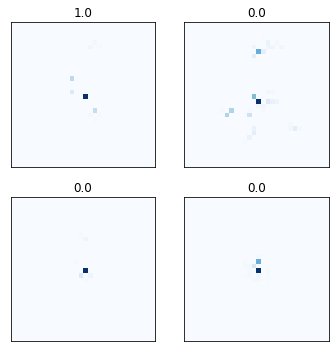

In [2]:
# jet images, 32x32 pixels (eta, phi) plane, with energy deposit on each calorimetric cell
# targets: binary label 0, 1, nornmal and merged jet

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim


with np.load('simCLR_dataset.npz') as f:
    train_features = f['train_features']
    train_targets = f['train_targets']

print("data shape: ",train_features.shape)
print(train_targets.shape)

import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
for i in range(4):
  ax = plt.subplot(2, 2, i+1)
  ax.imshow(train_features[i], cmap='Blues')
  ax.set_title(train_targets[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.tight_layout()

## Data is not similar to "real natural images " Check the distribution of values!


maximun value :  399.883


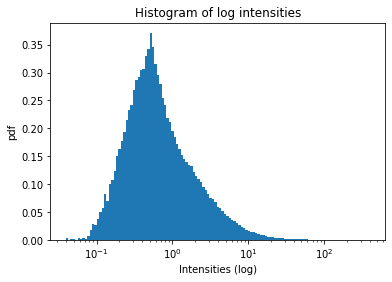

In [3]:
n_bin = 128
print("maximun value : ",np.max(train_features))
logbins = np.geomspace(train_features[train_features>0].min(), train_features.max(), n_bin)
plt.figure(111)
plt.hist(train_features.ravel(), bins=logbins,density=True)
plt.xscale('log')
plt.ylabel("pdf")
plt.xlabel("Intensities (log)")
plt.title("Histogram of log intensities")
plt.show()

## To visualize the rich structure of the data is better to show the logbins

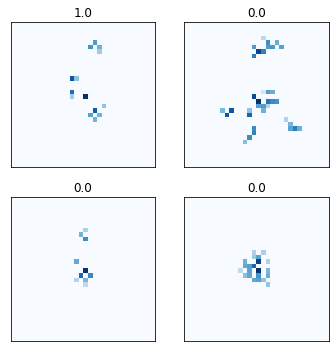

In [4]:


plt.figure(figsize=(5,5))
for i in range(4):
  ax = plt.subplot(2, 2, i+1)
  ax.imshow(np.digitize(train_features[i],logbins)/n_bin, cmap='Blues')
  ax.set_title(train_targets[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.tight_layout()

In [5]:
# some useful libs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

1.10.0+cu111
0.11.1+cu111


In [6]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

# of GPUs available:  1
First GPU type:  Tesla K80
Computation device: cuda



In [7]:
# preprocess data: split on training, validation, test
# normalize fatures (pixels) in [0,1]

from sklearn.preprocessing import MinMaxScaler ,StandardScaler

LOG_BINS = False
Z_SCORE = True
if Z_SCORE:
  scaler = StandardScaler()
else:
  scaler = MinMaxScaler()

# training, validation, test split
from sklearn.model_selection import train_test_split
testset_frac = 0.2 # test set fraction wrt whole samples
valiset_frac = 0.25 # validation set fraction wrt training+validation

X_train,X_test,Y_train,Y_test = train_test_split(train_features,train_targets,test_size=testset_frac, shuffle=True, random_state=1234)
X_train,X_vali,Y_train,Y_vali = train_test_split(X_train,Y_train,test_size=valiset_frac, shuffle=True, random_state=1234)

X_train = X_train.reshape(X_train.shape[0],32*32)
X_vali = X_vali.reshape(X_vali.shape[0],32*32)
X_test = X_test.reshape(X_test.shape[0],32*32)

if LOG_BINS:
    n_bin = 256
    logbins = np.geomspace(X_train[X_train>0].min(), X_train.max(), n_bin)
    X_train = np.digitize(X_train,logbins)
    X_vali = np.digitize(X_vali,logbins)
    X_test = np.digitize(X_test,logbins)
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_vali = scaler.transform(X_vali)
    X_test = scaler.transform(X_test)

else:
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_vali = scaler.transform(X_vali)
    X_test = scaler.transform(X_test)

    
X_train = X_train.reshape(X_train.shape[0],32,32)
X_vali = X_vali.reshape(X_vali.shape[0],32,32)
X_test = X_test.reshape(X_test.shape[0],32,32)

X_train = np.expand_dims(X_train, -1)
X_vali = np.expand_dims(X_vali, -1)
X_test = np.expand_dims(X_test, -1)

print('X_train shape: ',X_train.shape)
print('Y_train shape: ',Y_train.shape)
print('X_vali shape: ',X_vali.shape)
print('Y_vali shape: ',Y_vali.shape)
print('X_test shape: ',X_test.shape)
print('Y_test shape: ',Y_test.shape)

X_train shape:  (12000, 32, 32, 1)
Y_train shape:  (12000,)
X_vali shape:  (4000, 32, 32, 1)
Y_vali shape:  (4000,)
X_test shape:  (4000, 32, 32, 1)
Y_test shape:  (4000,)


## Visualize the training set after the normalization

X_train max:  109.539955
X_train min:  -0.8123182


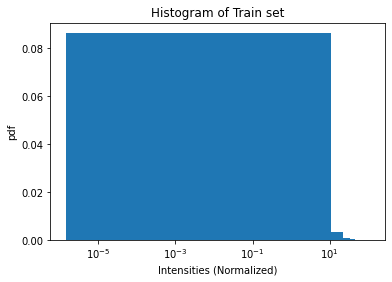

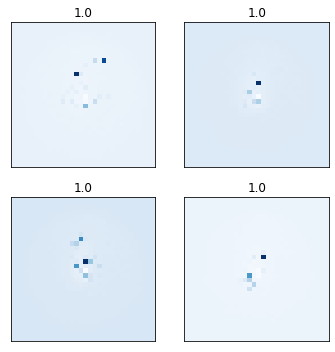

In [8]:
print('X_train max: ',X_train.max())
print('X_train min: ',X_train.min())

plt.figure(111)
if LOG_BINS:
  plt.hist(X_train[X_train>0].ravel(),logbins,density=True)
else:
    plt.hist(X_train[X_train>0].ravel(),density=True)

plt.ylabel("pdf")
plt.xlabel("Intensities (Normalized)")
plt.xscale('log')
plt.title("Histogram of Train set")
plt.show()

plt.figure(figsize=(5,5))
for i in range(4):
  ax = plt.subplot(2, 2, i+1)
  ax.imshow(X_train[i,:,:,0], cmap='Blues')
  ax.set_title(Y_train[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.tight_layout()

In [9]:
# transform numpy vectors to pytorch tensors
X_train_pt = torch.Tensor(X_train)
Y_train_pt = torch.Tensor(Y_train)
X_vali_pt = torch.Tensor(X_vali)
Y_vali_pt = torch.Tensor(Y_vali)
X_test_pt = torch.Tensor(X_test)
Y_test_pt = torch.Tensor(Y_test)

# switch channel dimension position as needed by pytorch (NOTE: in numpy/keras (dim1,dim2,..., channels) in pytorch (channel, dim1, dim2, ...))
X_train_pt = X_train_pt.permute(0,3,1,2)
X_vali_pt = X_vali_pt.permute(0,3,1,2)
X_test_pt = X_test_pt.permute(0,3,1,2)

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_vali_pt.shape)
print(Y_vali_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

torch.Size([12000, 1, 32, 32])
torch.Size([12000])
torch.Size([4000, 1, 32, 32])
torch.Size([4000])
torch.Size([4000, 1, 32, 32])
torch.Size([4000])


**Data generator definition**



In [10]:
from operator import indexOf
# create a custom dataset
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils

# custom class that takes an image and outputs n_views random ransformation according to the 
# base_transforms list 
class ContrastiveTransformations(object):
    def __init__(self, base_transforms):
        self.base_transforms = base_transforms
        

    def __call__(self, x):
        return self.base_transforms(x) 

class JetSubStructure(Dataset):
    """JetSubstructure dataset."""

    def __init__(self, data, labels, phase='train', transform=None):
        """
        Args:
            data: torch tensor containing images
            labels: torch tensor containing associated label
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.phase = phase
        self.data = data
        self.label = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]
        label = self.label[idx]

        if self.transform:
          if self.phase == 'train':
            sample = self.transform(sample)
          else: 
            sample = sample

        
        return sample, label
    
# Data-augmentation transformations
# compose 4 different transformations from the trochvision lib: random horizontal pixels flip, random vertical pixels flip, random rotation, and random crop of the image

contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomRotation(180.),
                                          transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                         ])

In [11]:
# create the dataset
train_dataset = JetSubStructure(data=X_train_pt, labels=Y_train_pt, phase='train', transform=ContrastiveTransformations( base_transforms=contrast_transforms))
val_dataset = JetSubStructure(data=X_vali_pt, labels=Y_vali_pt, phase='vali', transform=ContrastiveTransformations( base_transforms=contrast_transforms))
test_dataset = JetSubStructure(data=X_test_pt, labels=Y_test_pt, phase='vali')

In [12]:
from torch.utils.data import DataLoader
# We define a set of data loaders that we can use for various purposes later.
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


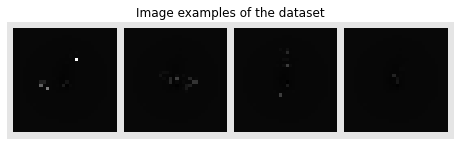

In [13]:
# Visualize some examples
NUM_IMAGES = 4
images = torch.stack([val_dataset[idx][0] for idx in range(NUM_IMAGES)], dim=0)#first is image indx, second is image/label/
img_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## Transformers for image classification

Transformers have been originally proposed to process sets (un-ordered lists of items) since it is a permutation-equivariant architecture, i.e., producing the same output permuted if the input is permuted. 

To apply Transformers to sequences (ordered lists), we need to add a positional encoding to the input feature vectors. Hopefully the model will learn by itself how to use this additional information.

In this session we will work with images following the procedure proposed by Dosovitskiy et al.  in their paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale". 

Specifically, the Vision Transformer is a model for image classification that views images as sequences of smaller patches. 

As a preprocessing step, we need to divide the image in a sequence of small patches.

Each of those patches is considered to be a "word"/"token" and projected to a feature space. 

Then we will add an a spatial encoding (additional paramenters that will encode the position of each patch in the larger image) to each patch. After this preprocessing we can apply a Transformer as usual to this sequence and start training it for our task.

Transformenrs can work with high resolution images and learn how to use context from very distant portion of the image.


Probably 64 patches of 8 pixels for these small images are a little too much... Try to optimize it!

In [14]:
def img_to_patch(x, patch_size, flatten_channels=True):
    # flatten channels is more importatnt as a parameter if we are working with multi channel images
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

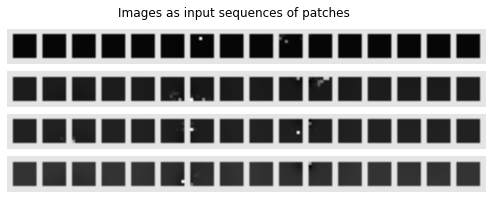

In [15]:
img_patches = img_to_patch(images, patch_size=8, flatten_channels=False)

fig, ax = plt.subplots(images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()


Compared to the original images, it is much harder to recognize the objects from those patch lists now. Still, this is the input we provide to the Transformer for classifying the images. The model has to learn itself how it has to combine the patches to recognize the objects. The inductive bias in CNNs that an image is a grid of pixels, is lost in this input format.

After we have looked at the preprocessing, we can now start building the Transformer model. 

 Further, we use the Pre-Layer Normalization version of the Transformer blocks proposed by Ruibin Xiong et al. in 2020. 
 
 The idea is to apply Layer Normalization not in between residual blocks, but instead as a first layer in the residual blocks. This reorganization of the layers supports better gradient flow and removes the necessity of a warm-up stage. 

In [16]:
class AttentionBlock(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network 
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()
        
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
        
    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

Now we have all modules ready to build our own Vision Transformer. Besides the Transformer encoder, we need the following modules:

- A linear projection layer that maps the input patches to a feature vector of larger size. It is implemented by a simple linear layer that takes each patch independently as input.

- A classification token that is added to the input sequence. We will use the output feature vector of the classification token (CLS token in short) for determining the classification prediction.

- Learnable positional encodings that are added to the tokens before being processed by the Transformer. Those are needed to learn position-dependent information, and convert the set to a sequence. Since we usually work with a fixed resolution, we can learn the positional encodings instead of having the pattern of sine and cosine functions [Here you can find a good explanation of positional encodings for NLP sequences with varing length](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

- An MLP head that takes the output feature vector of the CLS token, and maps it to a classification prediction. This is usually implemented by a small feed-forward network or even a single linear layer.



In [17]:
class VisionTransformer(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
           
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and 
                      on the input encoding
        """
        super().__init__()
        
        self.patch_size = patch_size
        
        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 1),# cross entropy already has a softmax integrated while BCE does not. So a sigmoid is added # if **multiclass** this is the part to modify!
            nn.Sigmoid()
        )
        self.dropout = nn.Dropout(dropout)
        
        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))# this is our positional  embedding. It is initialized as a random number but it is learnable so it will be optimized during training.
    
    
    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)
        
        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]
        
        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)
        
        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [18]:

model_kwargs={
                                'embed_dim': 64,
                                'hidden_dim': 128,
                                'num_heads': 8,
                                'num_layers':4,
                                'patch_size': 8,
                                'num_channels': 1,
                                'num_patches': 64,
                                'dropout': 0.30
                            }

model = VisionTransformer(**model_kwargs)

In [19]:
xb,yb=next(iter(val_loader))
print(xb.shape)
print(yb.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 1, 32, 32])
torch.Size([256])


In [20]:
out=model(xb)

In [21]:
print(out.shape)

torch.Size([256, 1])


In [22]:
yb

tensor([1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
        0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1.,
        0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
        0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 

In [23]:

print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,32,32))
else:
  summary(model, input_size=(1,32,32))

VisionTransformer(
  (input_layer): Linear(in_features=64, out_features=64, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU()
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=128, out_features=64, bias=True)
        (4): Dropout(p=0.3, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm_2): LayerNorm((64,), eps=1e-05, eleme

In [24]:
#loss 
loss_func = nn.BCELoss() #binary cross entropy loss

#metric accuracy
def accuracy(out, yb):
    preds = out.cpu().reshape(-1).detach().numpy().round()
    return (preds == yb.cpu().detach().numpy()).mean()

metric_func = accuracy

# optim
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[25,50,80], gamma=0.2)

# scheduler for step decay lr schedule
#scheduler = optim.lr_scheduler.StepLR(opt, 10, gamma=0.1, last_epoch=-1, verbose=True)

# move the model into the GPU
model.to('cpu')
print('The model is in the: ', next(model.parameters()).device)
model.to(device)
print('now the model is in the: ', next(model.parameters()).device)

The model is in the:  cpu
now the model is in the:  cuda:0


In [25]:
#Checkpoints (to save model parameters during training)
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that 
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model.pth')

In [26]:
#training loop

epochs = 100

import time

save_best_model = SaveBestModel()

# lists to save loss and metric history
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

#loop over epochs
for epoch in range(epochs):
    t0 = time.time()

    #training step
    model.train()

    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for xb, yb in train_loader: #takes a batch from the train dataloader 
        counter += 1 
        xb=xb.type(torch.float).to(device) #move troch tensors to device (cpu or GPU)
        yb=yb.type(torch.float).to(device)
        
        pred = model(xb) #get prediction for batch
        loss = loss_func(pred, torch.unsqueeze(yb,1)) #compute loss
        metric = metric_func(pred, yb) #compute metric

        train_loss += loss.item() #update total loss
        train_metric += metric.item() #update total metric

        # backpropagation
        loss.backward()
        # update weights
        opt.step()
        # set to zero gradients for the next step
        opt.zero_grad()
 
    # normalize loss and metric by number of batches
    train_loss = train_loss/counter
    train_metric = train_metric/counter

    # update history
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)


    # evaluation setp (same as trainign but w/o backpropagation)
    model.eval()

    vali_loss = 0.0
    vali_metric = 0.0
    counter = 0
    with torch.no_grad():
      for xb, yb in val_loader:
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.float).to(device)
        pred = model(xb)
        vloss = loss_func(pred, torch.unsqueeze(yb,1))
        vmetric = metric_func(pred, yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()
        
    vali_loss = vali_loss/counter
    vali_metric = vali_metric/counter    

    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    #save best model
    save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)   

    elapsed_time = time.time()-t0
    current_lr = lr_scheduler.get_last_lr()[0]
    print("epoch: %d, time(s): %.2f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f,  lr : %1.2e" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric,current_lr))

    # update learning rate schedule
    lr_scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Best validation loss: 0.7179849781095982

Saving best model for epoch: 1

epoch: 1, time(s): 10.96, train loss: 0.697497, train metric: 0.515795, vali loss: 0.717985, vali metric: 0.512012,  lr : 1.00e-03

Best validation loss: 0.5894642099738121

Saving best model for epoch: 2

epoch: 2, time(s): 10.87, train loss: 0.682137, train metric: 0.556471, vali loss: 0.589464, vali metric: 0.746289,  lr : 1.00e-03

Best validation loss: 0.5573327615857124

Saving best model for epoch: 3

epoch: 3, time(s): 9.35, train loss: 0.647966, train metric: 0.625170, vali loss: 0.557333, vali metric: 0.731836,  lr : 1.00e-03
epoch: 4, time(s): 7.36, train loss: 0.622178, train metric: 0.664062, vali loss: 0.608960, vali metric: 0.654834,  lr : 1.00e-03

Best validation loss: 0.5380793958902359

Saving best model for epoch: 5

epoch: 5, time(s): 7.39, train loss: 0.615753, train metric: 0.666525, vali loss: 0.538079, vali metric: 0.743457,  lr : 1.00e-03

Best validation loss: 0.5341639146208763

Savin

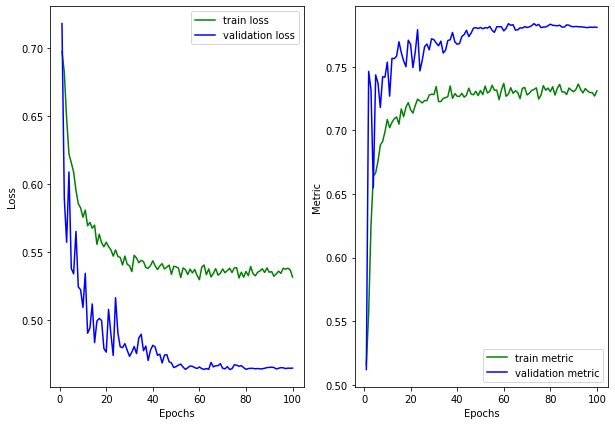

In [27]:
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()